In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(0)

In [2]:
log    = lambda x: np.log(x)
loglog = lambda x: np.log(np.log(x))

In [3]:
def confident_interval_indices(vector, confidence_level=0.50):
    mean = np.mean(vector)
    std_dev = np.std(vector)
    margin_error = std_dev * norm.ppf(1 - (1 - confidence_level) / 2)
    lower_bound = mean - margin_error
    upper_bound = mean + margin_error
    indices = np.where((vector >= lower_bound) & (vector <= upper_bound))[0]

    return indices

In [4]:
def plot_feature_target(dataset_name, feature_name, feature_engineer, feature_engineer_name, ax):
    features_df = pd.read_csv('training_data/' + dataset_name + '/inputs.csv')
    targets_df  = pd.read_csv('training_data/' + dataset_name + '/outputs.csv')

    feature = features_df[feature_name].to_numpy()
    feature = feature_engineer(feature)
    small_target = targets_df['min.log.lambda'].to_numpy()
    big_target   = targets_df['max.log.lambda'].to_numpy()

    # filter
    sampled_indices = confident_interval_indices(feature, confidence_level=0.9)
    sampled_indices = np.random.choice(sampled_indices, 500, replace=False)
    feature = feature[sampled_indices]
    small_target = small_target[sampled_indices]
    big_target = big_target[sampled_indices]

    # Plotting
    ax.scatter(small_target, feature, label='small target', color='black', marker='o', facecolors='none', edgecolors='black', s=10)
    ax.scatter(big_target, feature, label='big target', color='black', marker='o', s=10)

    for i in range(len(small_target)):
        linewidth=0.1
        if(small_target[i] == -np.inf):
            ax.plot([np.min(small_target[small_target > -np.inf]) - 0.1, big_target[i]], [feature[i], feature[i]], color='black', linestyle='-', linewidth=linewidth)
        if(big_target[i] == np.inf):
            ax.plot([small_target[i], np.max(big_target[big_target < np.inf]) + 0.1], [feature[i], feature[i]], color='black', linestyle='-', linewidth=linewidth)
        ax.plot([small_target[i], big_target[i]], [feature[i], feature[i]], color='black', linestyle='-', linewidth=linewidth)

    ax.set_xlabel('optimal ' + r'$\log\lambda$')
    ax.set_ylabel(feature_engineer_name + " " + feature_name)
    ax.set_title('feature: ' + feature_name)

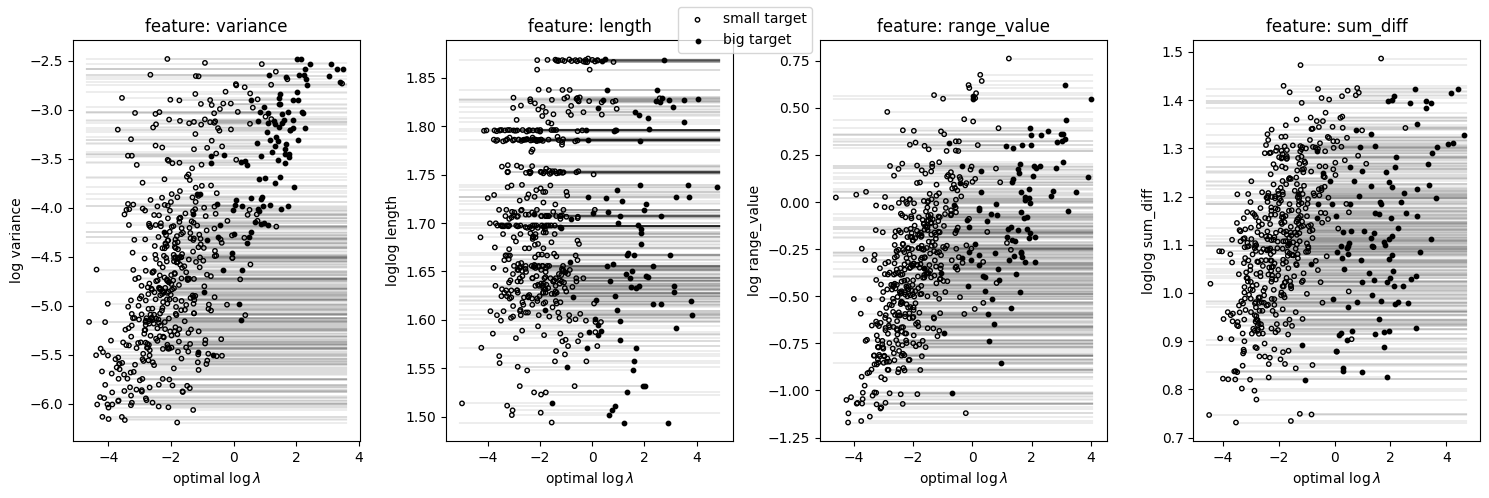

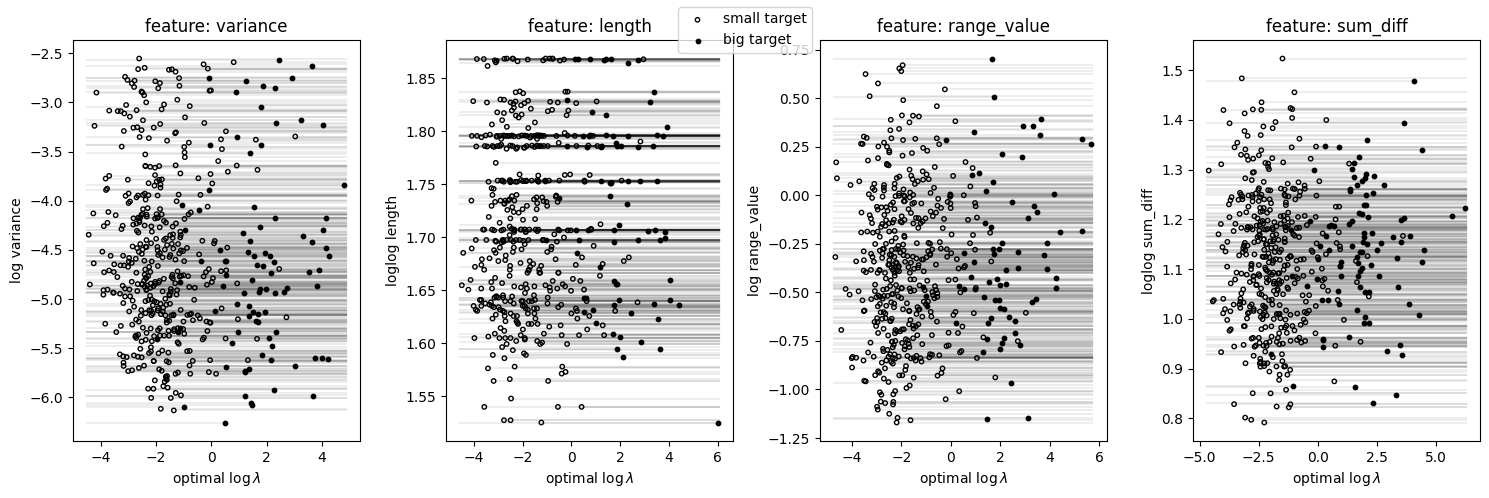

In [5]:
for dataset_name in ['detailed', 'systematic']:
    # Create subplots
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    feature_names = ['variance', 'length', 'range_value', 'sum_diff']
    legend_handles = []
    legend_labels = []
    for i, feature_name in enumerate(feature_names):
        if (feature_name in ['variance', 'range_value']):
            feature_engineer = log
            feature_engineer_name = 'log'
        else:
            feature_engineer = loglog
            feature_engineer_name = 'loglog'
        plot_feature_target(dataset_name, feature_name, feature_engineer, feature_engineer_name, axs[i])
        # Collect handles and labels for each subplot
        h, l = axs[i].get_legend_handles_labels()
        # Only add unique handles and labels to the list
        for handle, label in zip(h, l):
            if label not in legend_labels:
                legend_handles.append(handle)
                legend_labels.append(label)

    # Create a combined legend for the entire figure
    fig.legend(legend_handles, legend_labels, loc='upper center')

    plt.tight_layout()
    plt.savefig('figures/' + dataset_name + '/features_targets.pdf')
    plt.savefig('figures/' + dataset_name + '/features_targets.jpg')